In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from marginal import MarginalExplainer

In [2]:
n = 1000
d = 3
batch_size = 50
learning_rate = 0.1

In [3]:
W = np.array([-2.0, -3.0, 1.0])
b = 0.0
X = np.random.randn(n, d)
y = np.dot(X, W) + b

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(3,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=True))

In [5]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [6]:
model.fit(X, y, epochs=10, verbose=2)

Train on 1000 samples
Epoch 1/10
1000/1000 - 0s - loss: 2.8206 - mean_absolute_error: 0.8756 - mean_squared_error: 2.8206
Epoch 2/10
1000/1000 - 0s - loss: 3.9005e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 3.9005e-04
Epoch 3/10
1000/1000 - 0s - loss: 9.0093e-08 - mean_absolute_error: 1.6508e-04 - mean_squared_error: 9.0093e-08
Epoch 4/10
1000/1000 - 0s - loss: 2.4735e-11 - mean_absolute_error: 2.7208e-06 - mean_squared_error: 2.4735e-11
Epoch 5/10
1000/1000 - 0s - loss: 9.6802e-14 - mean_absolute_error: 2.0796e-07 - mean_squared_error: 9.6802e-14
Epoch 6/10
1000/1000 - 0s - loss: 8.5593e-14 - mean_absolute_error: 1.9065e-07 - mean_squared_error: 8.5593e-14
Epoch 7/10
1000/1000 - 0s - loss: 8.5751e-14 - mean_absolute_error: 1.9156e-07 - mean_squared_error: 8.5751e-14
Epoch 8/10
1000/1000 - 0s - loss: 8.5576e-14 - mean_absolute_error: 1.9113e-07 - mean_squared_error: 8.5576e-14
Epoch 9/10
1000/1000 - 0s - loss: 8.5957e-14 - mean_absolute_error: 1.9202e-07 - mean_squared_erro

In [7]:
primal_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:20], verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W1021 14:50:34.899194 140094045292352 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 20/20 [00:01<00:00, 19.95it/s]


In [8]:
dual_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:01<00:00, 19.05it/s]


In [9]:
average_explainer = MarginalExplainer(model, X[20:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:20], verbose=True)

100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


In [10]:
shap_values = X * W[np.newaxis, :]

In [11]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:20])

In [12]:
data_df = pd.DataFrame({
    'True SHAP Values':        shap_values[:20].flatten(),
    'Sampled Primal Effects':  primal_effects.flatten(),
    'Sampled Dual Effects':    dual_effects.flatten(),
    'Sampled Average Effects': average_effects.flatten(),
    'Kernel SHAP Values':      kernel_shap.flatten()
})

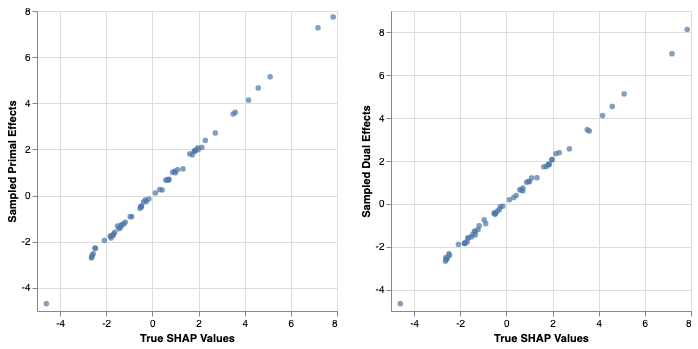

In [16]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('True SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Primal Effects', 'Sampled Dual Effects'])

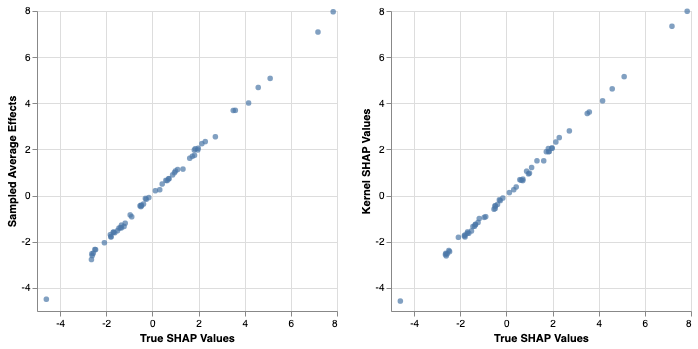

In [17]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('True SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative')
).properties(width=300, height=300).repeat(column=['Sampled Average Effects', 'Kernel SHAP Values'])